## 의존성 설치

In [2]:
!pip install --upgrade pip
!pip install -q torch=="2.5.1"
!pip install -q tiktoken=="0.7.0"

In [3]:
from importlib.metadata import version

print("torch version:", version('torch'))
print("tiktoken version:", version('tiktoken'))

torch version: 2.5.1
tiktoken version: 0.7.0


## 텍스트를 토큰으로 만들기
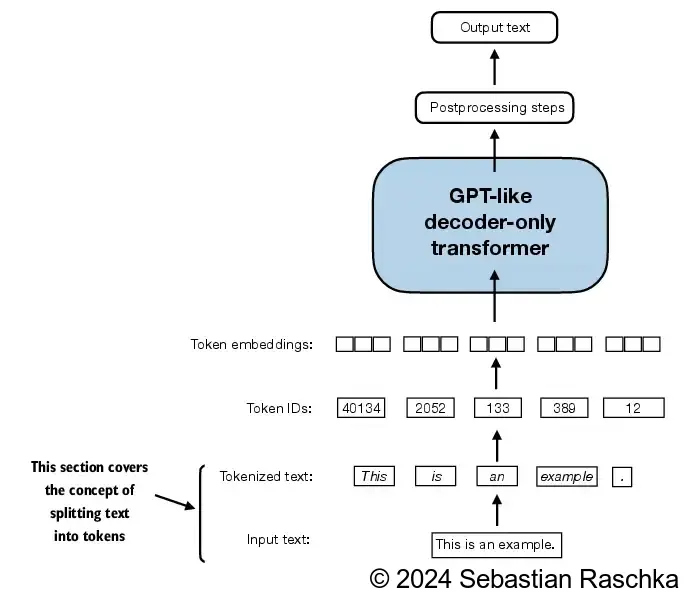  

텍스트의 출처는 Edith Wharton의 영화 `The Verdict` 입니다.

In [4]:
import os
import urllib.request

FILE_PATH = "../data/the-verdict.txt"
if not os.path.exists(FILE_PATH):
    url = ("https://raw.githubusercontent.com/rasbt/"
            "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
           "the-verdict.txt")
    urllib.request.urlretrieve(url, FILE_PATH)

In [5]:
with open(FILE_PATH, "r", encoding="utf-8") as f:
    raw_text = f.read()

print("Total number of character: ", len(raw_text))
print(raw_text[:99])

Total number of character:  20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


### 문자열을 쪼개고 숫자로 바꾸기 (토크타이징 + 임베딩) 

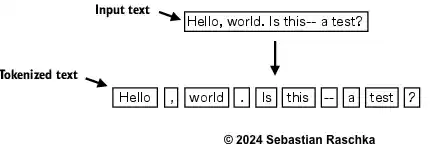

* 간단한 문장에 대해서 간단한 토크나이저 개발 + 위에서 가져온 문장에 적용

In [6]:
# 공백을 기준으로 분할하는 정규식
import re

text = "Hello, world. This, is a test."
result = re.split(r"(\s)", text)
print(result)

['Hello,', ' ', 'world.', ' ', 'This,', ' ', 'is', ' ', 'a', ' ', 'test.']


In [7]:
# 공백 + 콤마 + 쉼표를 포함한 기준으로 분할하는 정규식
result = re.split(r"([,.]|\s)", text)
print(result)

['Hello', ',', '', ' ', 'world', '.', '', ' ', 'This', ',', '', ' ', 'is', ' ', 'a', ' ', 'test', '.', '']


In [8]:
# 빈 문자열 및 공백을 제거
result = [item for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'This', ',', 'is', 'a', 'test', '.']


In [9]:
# 다른 문장부호를 포함한 최종 정규식
text = "Hello, world. Is this-- a test?"

result = re.split(r'([,.:;?_!"()\']|--|\s)', text)
result = [item.strip() for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']


In [10]:
# 실제 텍스트를 기반으로 토큰화 진행
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(preprocessed[:30])

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


In [11]:
# token의 개수
print(len(preprocessed))

4690


## 토큰을 토큰 id로 변환
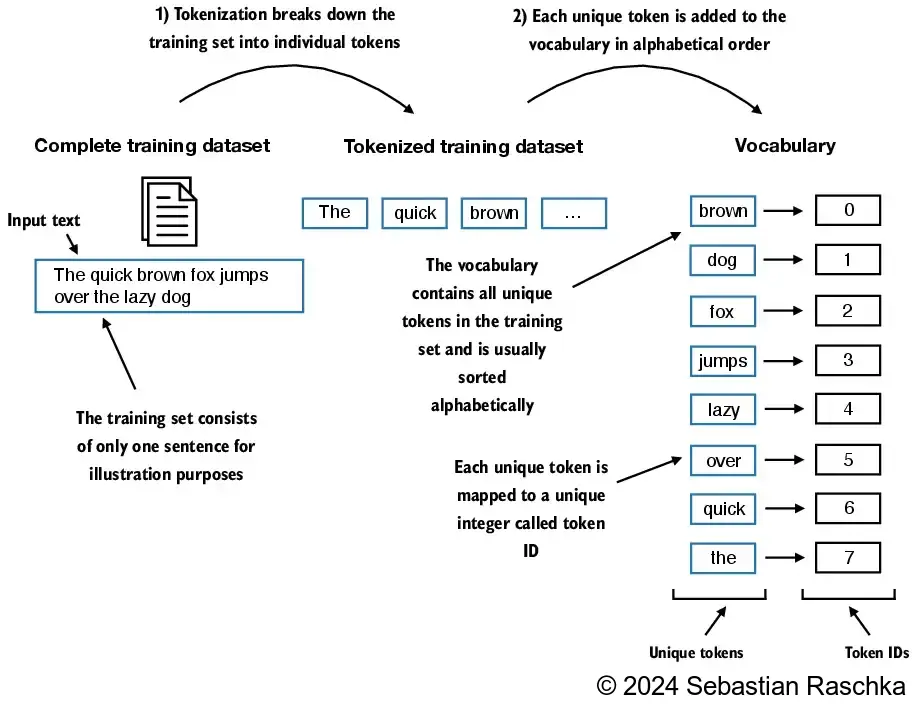

In [12]:
# 문장에 나오는 토큰들 중 중복을 제거, 어휘 사전 생성

all_words = sorted(set(preprocessed))
vocab_size = len(all_words)

print(vocab_size)

1130


In [13]:
vocab = {token:integer for integer, token in enumerate(all_words)}

In [14]:
for i, item in enumerate(vocab.items()):
    print(item)
    if i >= 50:
        break

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)
('But', 22)
('By', 23)
('Carlo', 24)
('Chicago', 25)
('Claude', 26)
('Come', 27)
('Croft', 28)
('Destroyed', 29)
('Devonshire', 30)
('Don', 31)
('Dubarry', 32)
('Emperors', 33)
('Florence', 34)
('For', 35)
('Gallery', 36)
('Gideon', 37)
('Gisburn', 38)
('Gisburns', 39)
('Grafton', 40)
('Greek', 41)
('Grindle', 42)
('Grindles', 43)
('HAD', 44)
('Had', 45)
('Hang', 46)
('Has', 47)
('He', 48)
('Her', 49)
('Hermia', 50)


아래 그림을 보면서 간단한 어휘 사전을 사용해서 영어 문장을 토크나이징 하는 방법을 알아보자

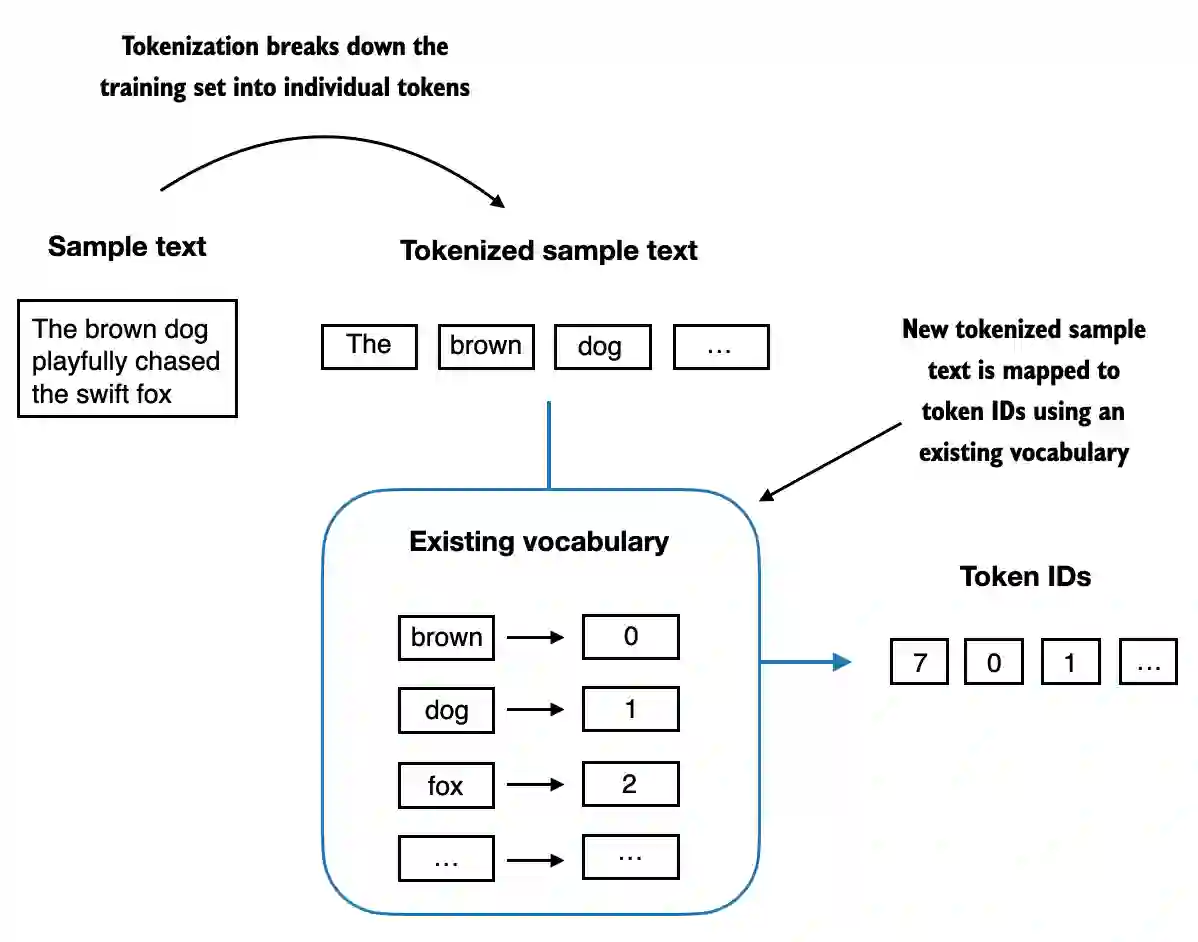
1. 영어 문장을 분절화해서 토큰으로 만들기
2. 각 토큰을 미리 정해진 어휘 사전을 사용해서 벡터로 변화
3. 그러면 토큰의 개수만큼 벡터가 나오게 되고, 이는 행렬의 형태로 나타난다.

In [15]:
# 인코딩과 디코딩을 하나의 토크나이저 클래스로 합치자
class SimpleTokenizerV1:
    def __init__(self, vocab: dict):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s, i in vocab.items()}
    
    def encode(self, text: str):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
    
    def decode(self, ids):
        text = " ".join([self.int_to_str[id] for id in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

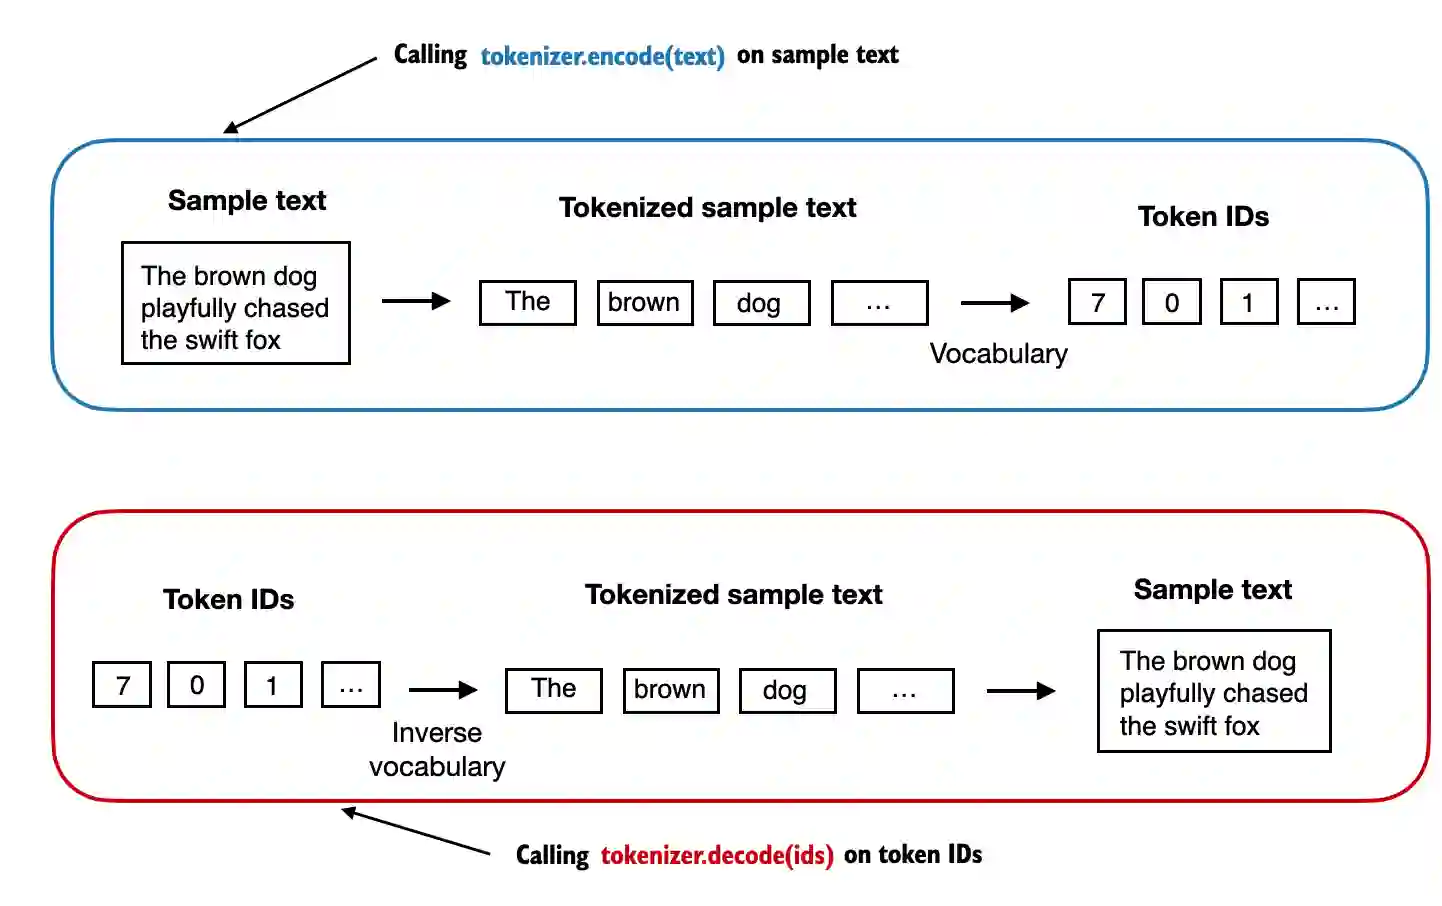
* `encode` 함수는 문자열을 토큰 id 숫자로 변환
* `decode` 함수는 토큰 id를 문자열로 변환

### decode함수 정규식 설명
`re.sub(src, dest, str)`는 str 문자열에 있는 `src` 정규식에 포함된 문자열을 `dest`로 바꾸는 함수
#### `r'\s+([,.?!"()\'])'`
* `\s+` 는 모든 space를 의미, tab, 공백 등등
* `()` 는 캡처 그룹을 의미하고 나중에 재사용 가능
* `[]` 안에 있는 문자들 중 하나만 있어도 가능

#### `\1`
* 첫번째 캡처 그룹을 의미. 여기서는 `([,.?!"()\'])` 정규식을 의미

즉 앞에 있는 공백을 제거하는 코드이며, `asdf , asdf` -> `asdf, asdf` 로 변환하는 코드이다.

In [18]:
tokenizer = SimpleTokenizerV1(vocab)

text = """"It's the last he painted, you know," 
           Mrs. Gisburn said with pardonable pride."""

# 문자열을 숫자로 바꾸기
ids = tokenizer.encode(text)
print(ids)

# 숫자를 문자열로 바꾸기
print(tokenizer.decode(ids))

[1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]
" It' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.


## 특수 토큰
어휘 사전에 없는 단어를 표현하거나 문자열의 마지막을 표현하기 위해서 특수한 토큰을 추가한다.
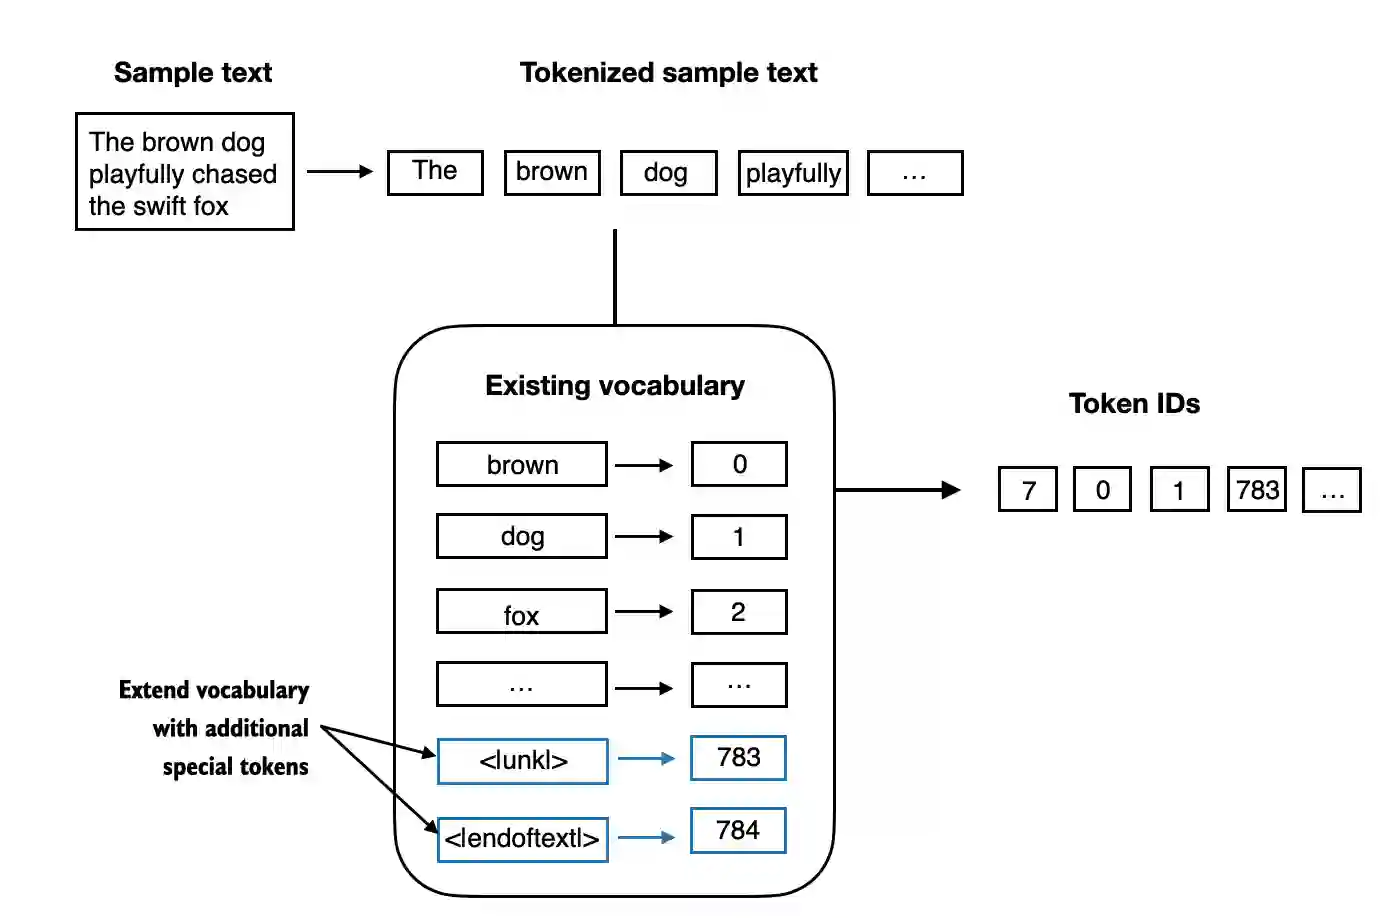
* 이런 토큰들은 LLM에게 추가 맥락을 제공하며 일반적으로 사용하는 토큰은 다음과 같다.
  * `[BOS] (beginning of sequence)`: 문자열의 시작
  * `[EOS] (end of sequence)`: 문자열의 마지막, 서로 다른 문서에서 가져온 문장을 구분하기 위해서 사용
  * `[PAD] (padding)`: LLM은 각자 정해진 context window 크기 만큼 토큰을 처리하는데 해당 크기보다 작은 문자열이 들어오면 이 토큰으로 채워서 길이를 맞춘다.
  * `[UNK] (unknown)`: 어휘사전에 없는 단어를 표현

기본적인 토큰 이외에도 각 토크나이저에 따라서 가지고있는 특징이 있다.
__GPT__ 는 위에서 언급한 토큰을 모두 사용하지 않고, `<|endoftext|>` 토큰만 사용한다. 
* 그 이유는 복잡성 감소를 위해서
* GPT에서는 이 토큰을 padding과 eos토큰 용도로 사용한다.

__GPT-2__ 에서는 BPE 토크나이저를 사용해서 `<UNK>` 토큰을 사용하지 않는다.
* BPE 토크나이저는 하나의 단어를 subword로 나눠서 토큰화를 하는 방식으로 어휘 사전에 없는 단어도 subword로 쪼개서 어떻게든 토큰화를 시키는 것이 특징이며 이후에 설명할 것이다.


이 책에서는 서로 다른 출처의 문서를 구분하기 위해서 `<endoftext>` 토큰을 사용한다.
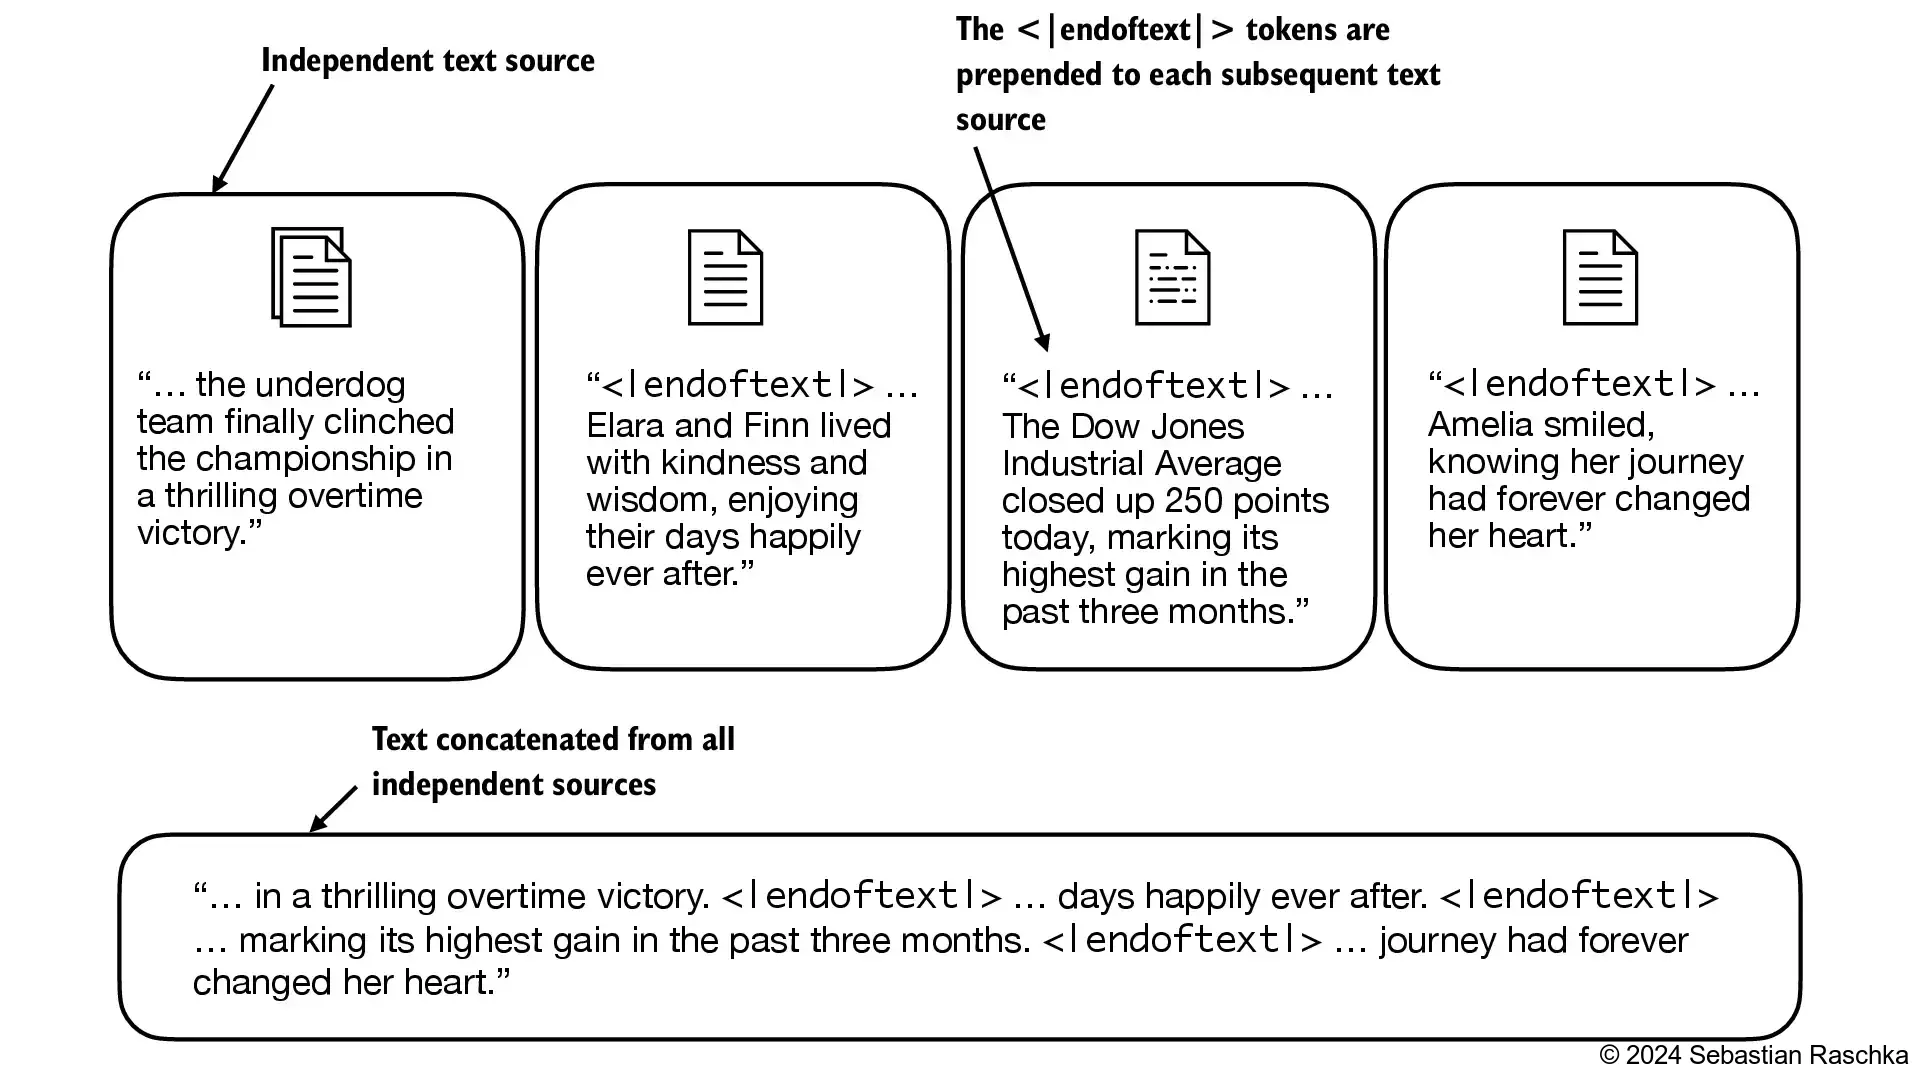


In [20]:
# 만약 기존 토크나이저에 어휘 사전 없는 단어를 넣는다면?

tokenizer = SimpleTokenizerV1(vocab)
text = "Hello, do you like tea. Is this-- a test?"
tokenizer.encode(text)

KeyError: 'Hello'

* 어휘 사전에 "Hello" 가 없기 때문에 발생한 에러
* 이런 경우를 해결하기 위해서 어휘사전에 없는 단어를 표현하는 토큰인 `<|unk|>` 를 추가
* 또한 여러 출처의 문서를 구분하기 위해서 `<|endoftext|>` 토큰을 추가. GPT-2에서 두개의 문장을 구분하거나 서로 다른 문서의 출처를 구분할때 사용.

In [22]:
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])

vocab = {token:integer for integer, token in enumerate(all_tokens)}
len(vocab.items())

1132

In [24]:
for i, item in enumerate(list(vocab.items())[-5:]):
    print(item)

('younger', 1127)
('your', 1128)
('yourself', 1129)
('<|endoftext|>', 1130)
('<|unk|>', 1131)


In [27]:
# 이제 <unk> 를 넣어보자
class SimpleTokenizerV2:
    def __init__(self, vocab: dict):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s, i in vocab.items()}
    
    def encode(self, text: str):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [item if item in self.str_to_int else "<|unk|>" for item in preprocessed]

        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
    
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.:;?!"()\'])', r'\1', text)
        return text

In [29]:
# 이제 새로운 토크나이저를 사용해보자
tokenizer = SimpleTokenizerV2(vocab)

text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."

text = " <|endoftext|> ".join((text1, text2))

print(text)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.


In [31]:
print(tokenizer.encode(text))
print(tokenizer.decode(tokenizer.encode(text)))

[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7]
<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.


## bytepair encoding

GPT-2는 토크나이저로 BPE를 사용한다.
* oov 단어를 다루기 위해서 어휘 사전에 없는 단어를 subword로 나눠 처리한다.
* 예를 들어 GPT-2가 `unfamiliarword` 라는 단어를 어휘사전에서 찾을 수 없다면 `[unfam, iliar, word]`로 나눠서 토큰화 한다.
* 실제 구현 코드는 다음에서 확인할 수 있다.
* 여기서는 openai의 [titoken](https://github.com/openai/tiktoken) 라이브러리를 사용하며 이는 rust로 작성해서 성능을 올렸다.
* 추가로 bpe를 직접 구현한 노트북과 벤치마크 성능 비교 노트북을 함께 첨부하니 학습에 도움이 될것이다.

In [33]:
import importlib
import tiktoken

print("tiktoken version:", importlib.metadata.version("tiktoken"))

tiktoken version: 0.7.0


In [ ]:
token = tiktoken.get_encoding("gpt2")

text = (
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
     "of someunknownPlace."
)

integers = tokenizer.encode(text, allowed_special={""})

// https://github.com/rasbt/LLMs-from-scratch/blob/main/ch02/01_main-chapter-code/ch02.ipynb